# Reducción de Complejidad e Interactividad

En este notebook exploraremos las siguientes técnicas:

- _Small Multiples_ o yuxtaposición de gráficos que utilizan la misma codificación visual, pero a diferentes subconjuntos de un dataset
- _Symbol Map_ o superimposición de gráficos que utilizan distinta codificación visual, pero del mismo dataset (aunque pueden ser atributos diferentes los puntos focales de cada vis.)
- _Widgets_, elementos de control que permiten actualizar una visualización de manera interactiva.

Usaremos la Encuesta Origen-Destino 2012 de Santiago.

In [22]:
from dotenv import load_dotenv
import os
import sys
from pathlib import Path
from aves.config import setup_style

load_dotenv()
setup_style()

AVES_ROOT = Path(os.environ['AVES_ROOT'])
EOD_PATH = AVES_ROOT / "data" / "external" / "EOD_STGO"
EOD_PATH

PosixPath('/home/egraells/resources/aves/data/external/EOD_STGO')

In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from aves.data import eod
from aves.features.utils import normalize_rows, normalize_columns

In [24]:
viajes = eod.read_trips(EOD_PATH)

# descartamos sectores que no sean relevantes en los orígenes y destinos de los viajes
viajes = viajes[
    (viajes["SectorOrigen"] != "Exterior a RM")
    & (viajes["SectorDestino"] != "Exterior a RM")
    & (viajes["SectorOrigen"] != "Extensión Sur-Poniente")
    & (viajes["SectorDestino"] != "Extensión Sur-Poniente")
    & pd.notnull(viajes["SectorOrigen"])
    & pd.notnull(viajes["SectorDestino"])
]

print(len(viajes))

83439


In [25]:
personas = eod.read_people(EOD_PATH)
hogares = eod.read_homes(EOD_PATH)
tabla = viajes.merge(personas).merge(hogares.drop('TipoDia', axis=1))

In [26]:
tabla["Peso"] = (
    tabla["FactorExpansion"] * tabla["FactorPersona"]
)

## Derivación

### ¿Existen diferencias de género en las actividades?

In [29]:
tabla.groupby(['Proposito', 'Sexo'])['Peso'].sum().unstack().astype(int).div(1000)

Sexo,Hombre,Mujer
Proposito,,
Al estudio,458.581,430.812
Al trabajo,1336.004,752.946
Buscar o Dejar a alguien,198.166,294.589
Buscar o dejar algo,21.891,18.928
Comer o Tomar algo,51.762,33.735
De compras,357.305,595.708
De salud,75.410,167.377
Otra actividad (especifique),86.731,125.806
Por estudio,45.193,44.442


<Axes: ylabel='Proposito'>

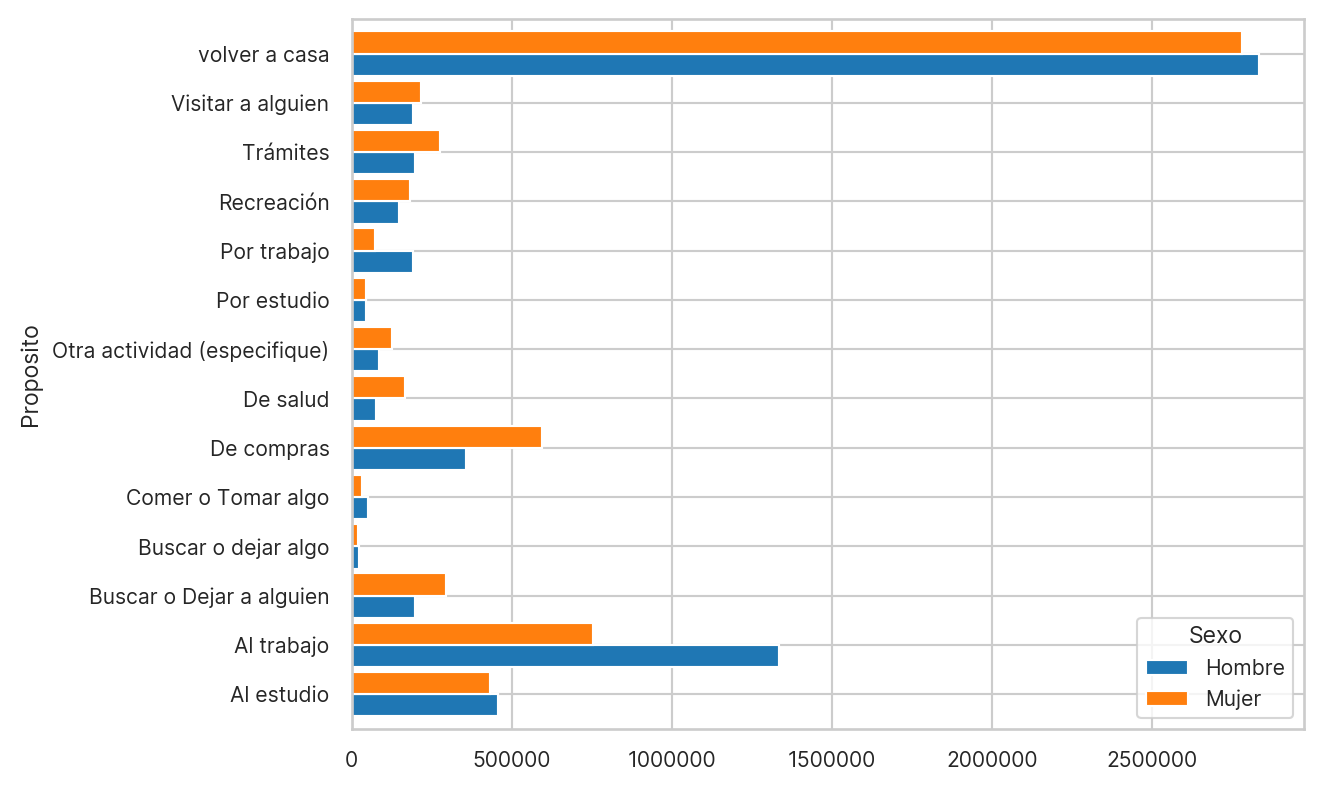

In [31]:
proposito_x_sexo = tabla.groupby(['Proposito', 'Sexo'])['Peso'].sum().unstack()
proposito_x_sexo.plot(kind='barh', width=0.9)

<Axes: ylabel='Proposito'>

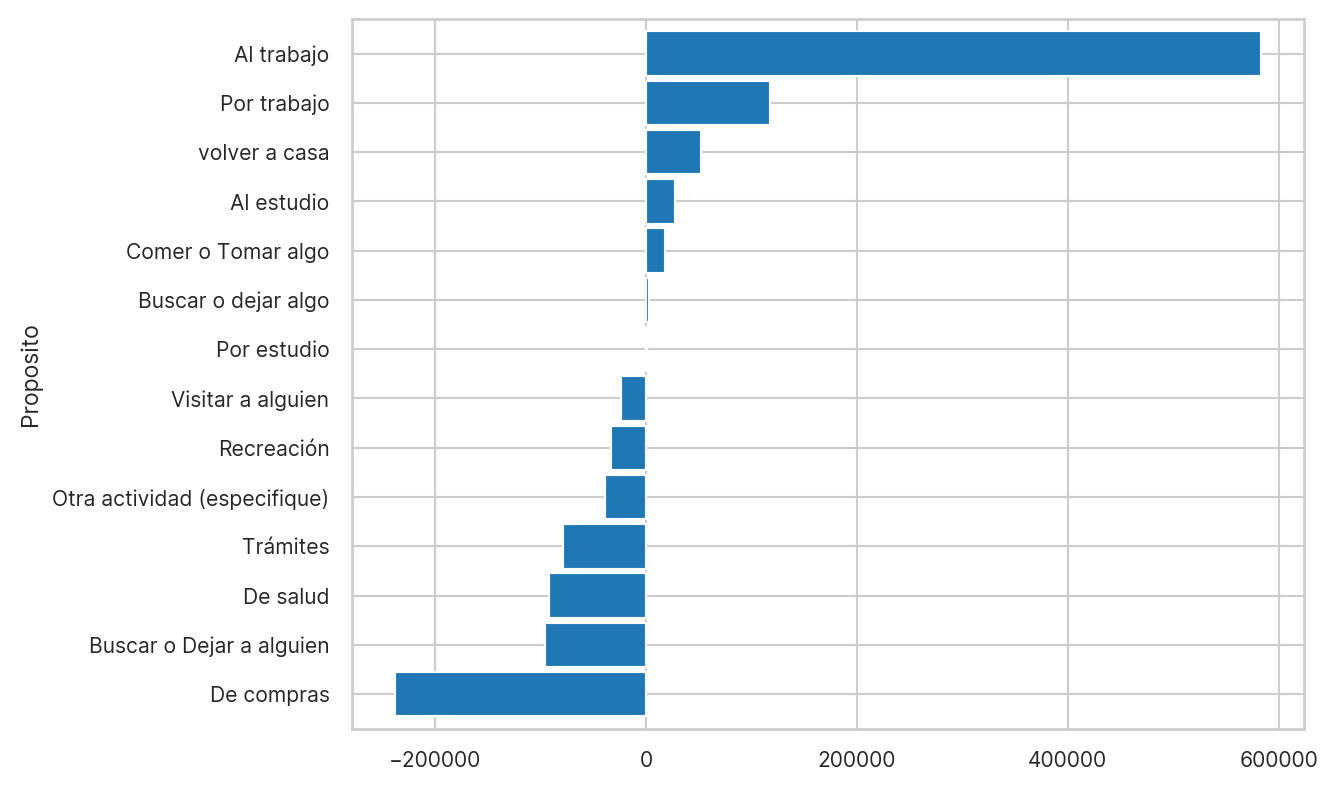

In [33]:
(proposito_x_sexo['Hombre'] - proposito_x_sexo['Mujer']).sort_values().plot(kind='barh', width=0.9)

<Axes: ylabel='Proposito'>

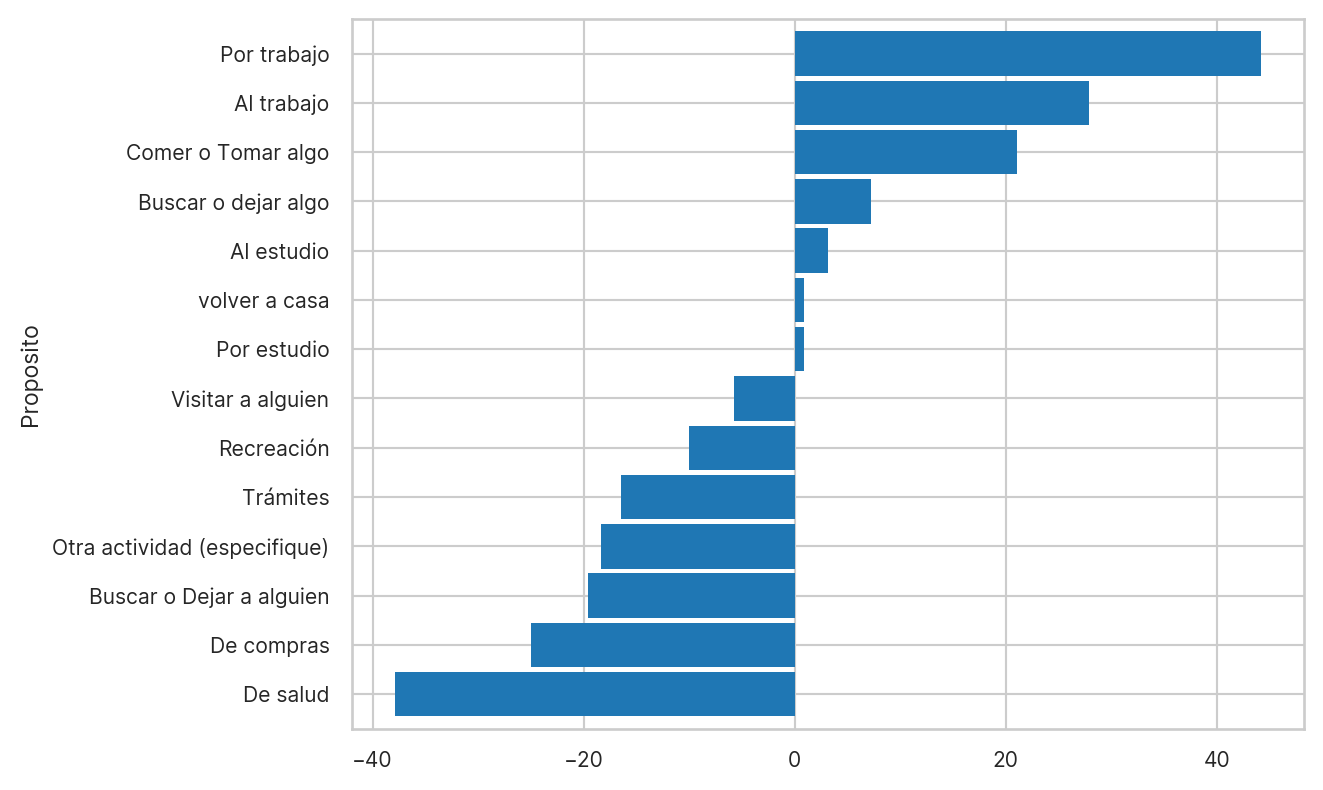

In [38]:
proposito_x_sexo.pipe(normalize_rows).pipe(lambda x: (x['Hombre'] - x['Mujer']) * 100).sort_values().plot(kind='barh', width=0.9, edgecolor='none')

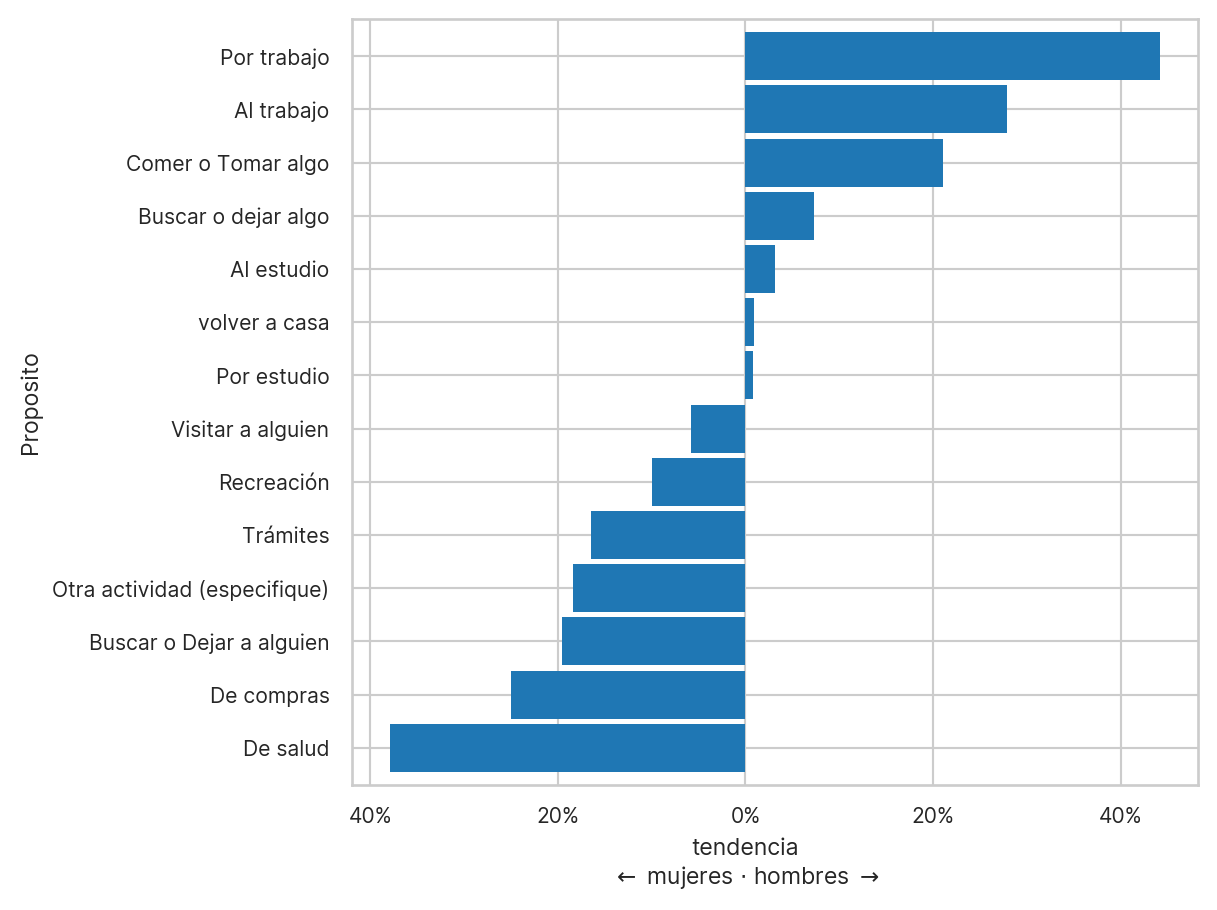

In [39]:
fig, ax = plt.subplots()

proposito_x_sexo.pipe(normalize_rows).pipe(
    lambda x: (x["Hombre"] - x["Mujer"]) * 100
).sort_values().plot(kind="barh", width=0.9, edgecolor="none", ax=ax)

# esto permite que pongamos porcentajes sin signo
ax.xaxis.set_major_formatter(lambda x, pos: f"{abs(x):g}%")

# esto permite que "centremos" los datos en 0 (y no necesariamente al medio del gráfico) para la posición x
ax.set_xlabel(
    "tendencia\n$\leftarrow$ mujeres $\cdot$ hombres $\\rightarrow$",
    ha="center",
    # flashbacks de computación gráfica ;)
    x=ax.transAxes.inverted().transform(ax.transData.transform((0, 0)))[0],
)

fig.tight_layout()

## Small Multiples

### ¿Cuáles son los perfiles etáreos asociados a los propósitos de viaje (actividades)?

Para esto necesitamos calcular la edad y un grupo etáreo.

In [40]:
tabla["Edad"] = 2013 - tabla["AnoNac"]
tabla["GrupoEtareo"] = tabla["Edad"] - (tabla["Edad"] % 5)
tabla['GrupoEtareo'].value_counts().sort_index()

GrupoEtareo
0     2020
5     3908
10    4231
15    5689
20    7863
25    7284
30    6568
35    6454
40    6878
45    6456
50    6615
55    5369
60    4349
65    3863
70    2599
75    1699
80    1061
85     402
90     119
95      12
Name: count, dtype: int64

In [41]:
rutina_x_edad = (
    tabla.groupby(["GrupoEtareo", "Proposito"])["Peso"]
    .sum()
    .unstack(fill_value=0)
    # enfoquémonos en propósitos de viaje frecuentes
    [['Al trabajo', 'Al estudio', 'De compras', 'De salud', 'Trámites', 'Visitar a alguien', 'Recreación']]
    .pipe(normalize_columns)
)

rutina_x_edad

Proposito,Al trabajo,Al estudio,De compras,De salud,Trámites,Visitar a alguien,Recreación
GrupoEtareo,,,,,,,
0,0.000252,0.043456,0.038422,0.055425,0.017456,0.040310,0.058796
5,0.000366,0.217408,0.032631,0.027848,0.010161,0.051197,0.088355
10,0.000317,0.227799,0.030554,0.014052,0.010095,0.053238,0.083770
15,0.011615,0.234775,0.031305,0.033019,0.022448,0.076087,0.113209
20,0.079360,0.171328,0.044814,0.037989,0.062892,0.093937,0.084641
25,0.129644,0.068727,0.076135,0.045167,0.053879,0.120515,0.102597
30,0.124840,0.017036,0.055544,0.041304,0.063603,0.091070,0.086227
35,0.121212,0.010406,0.073117,0.057335,0.064114,0.058638,0.057994
40,0.117190,0.002433,0.085243,0.048809,0.107063,0.041644,0.063954


<Axes: xlabel='GrupoEtareo'>

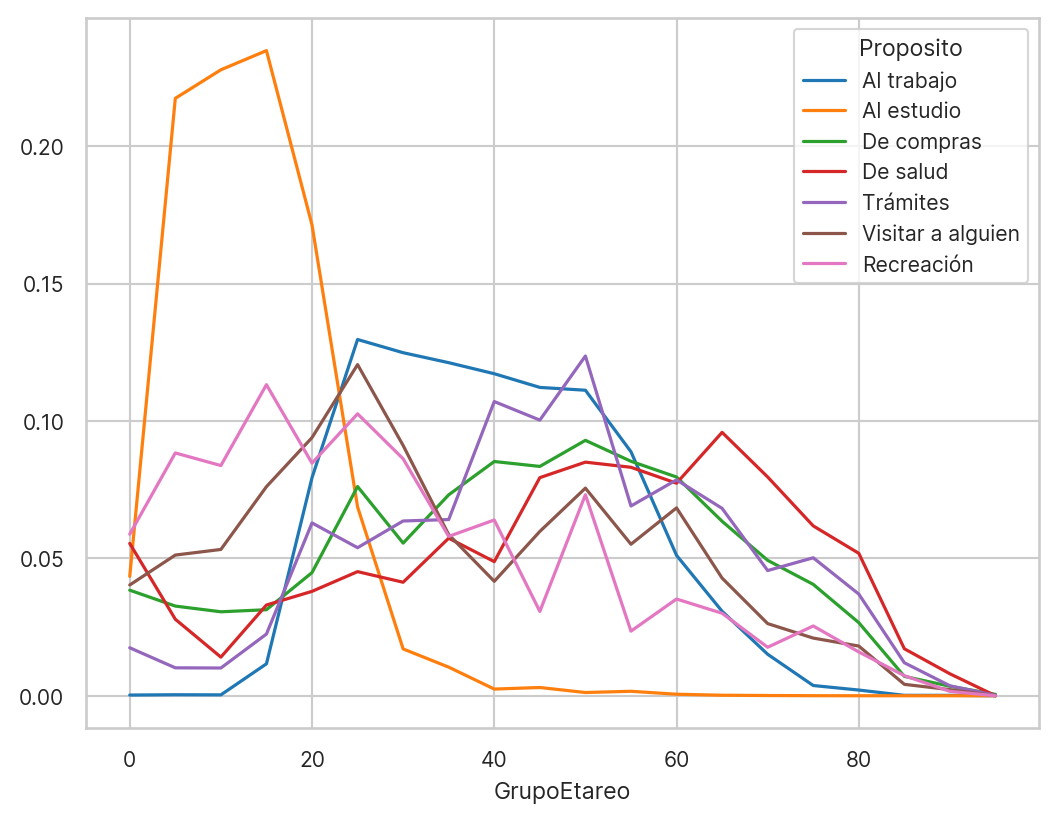

In [42]:
rutina_x_edad.plot()

Ya que el resultado es una tabla, podríamos utilizar directamente un _heatmap_:

In [43]:
res = sns.choose_colorbrewer_palette('sequential', as_cmap=True)

interactive(children=(Dropdown(description='name', options=('Greys', 'Reds', 'Greens', 'Blues', 'Oranges', 'Pu…

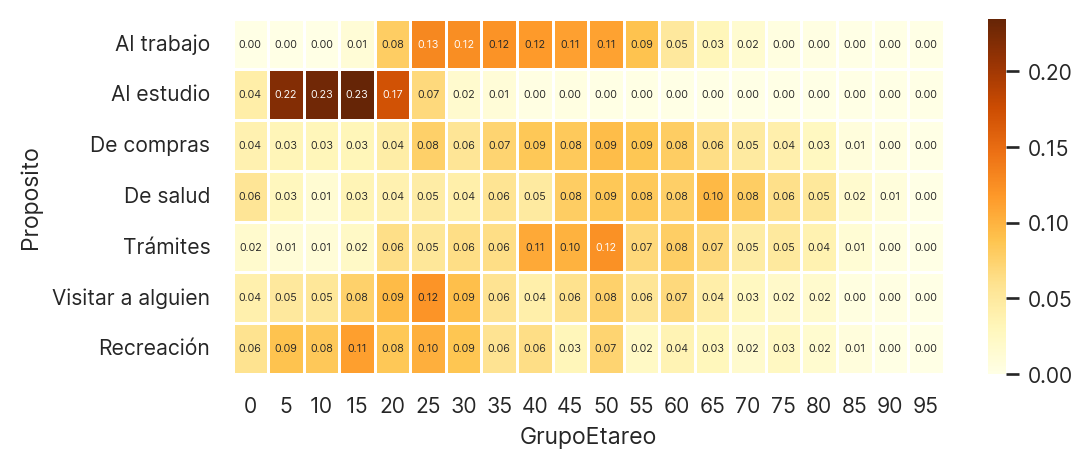

In [44]:
fig, ax = plt.subplots(figsize=(6, 2.5))
sns.heatmap(rutina_x_edad.T, cmap=res, ax=ax, annot=True, fmt='.2f', annot_kws={'fontsize': 4}, linewidth=1)

fig.tight_layout()

array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

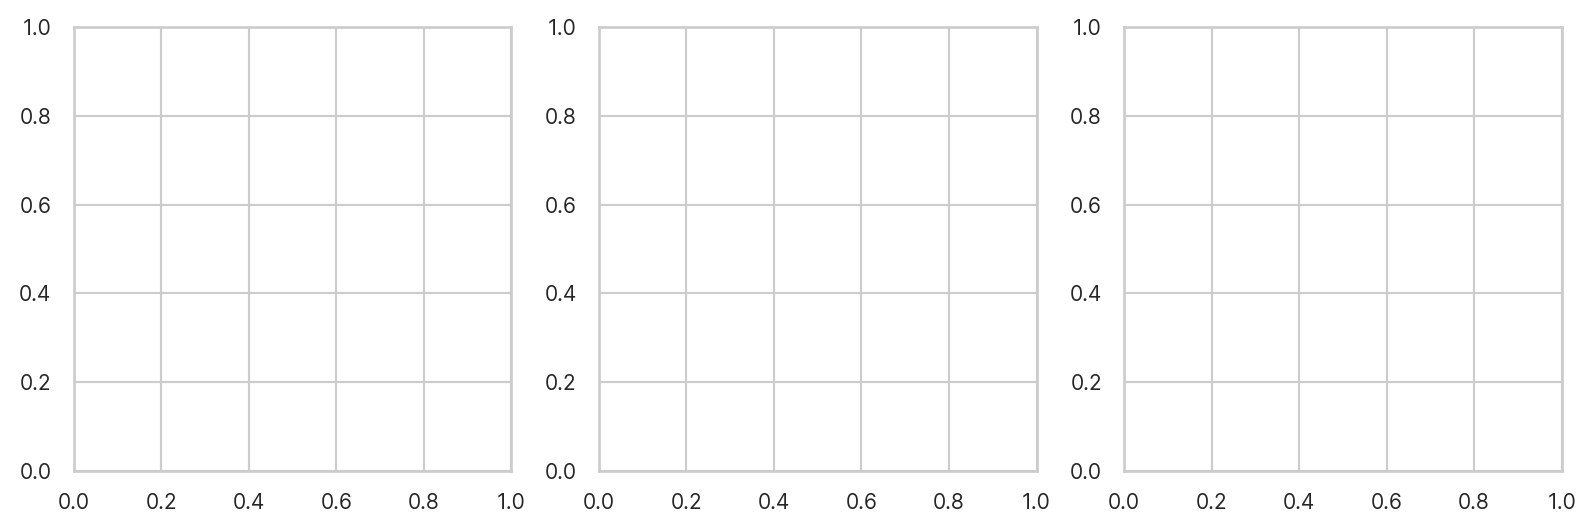

In [45]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
axes

/tmp/ipykernel_30377/3165357352.py:24: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


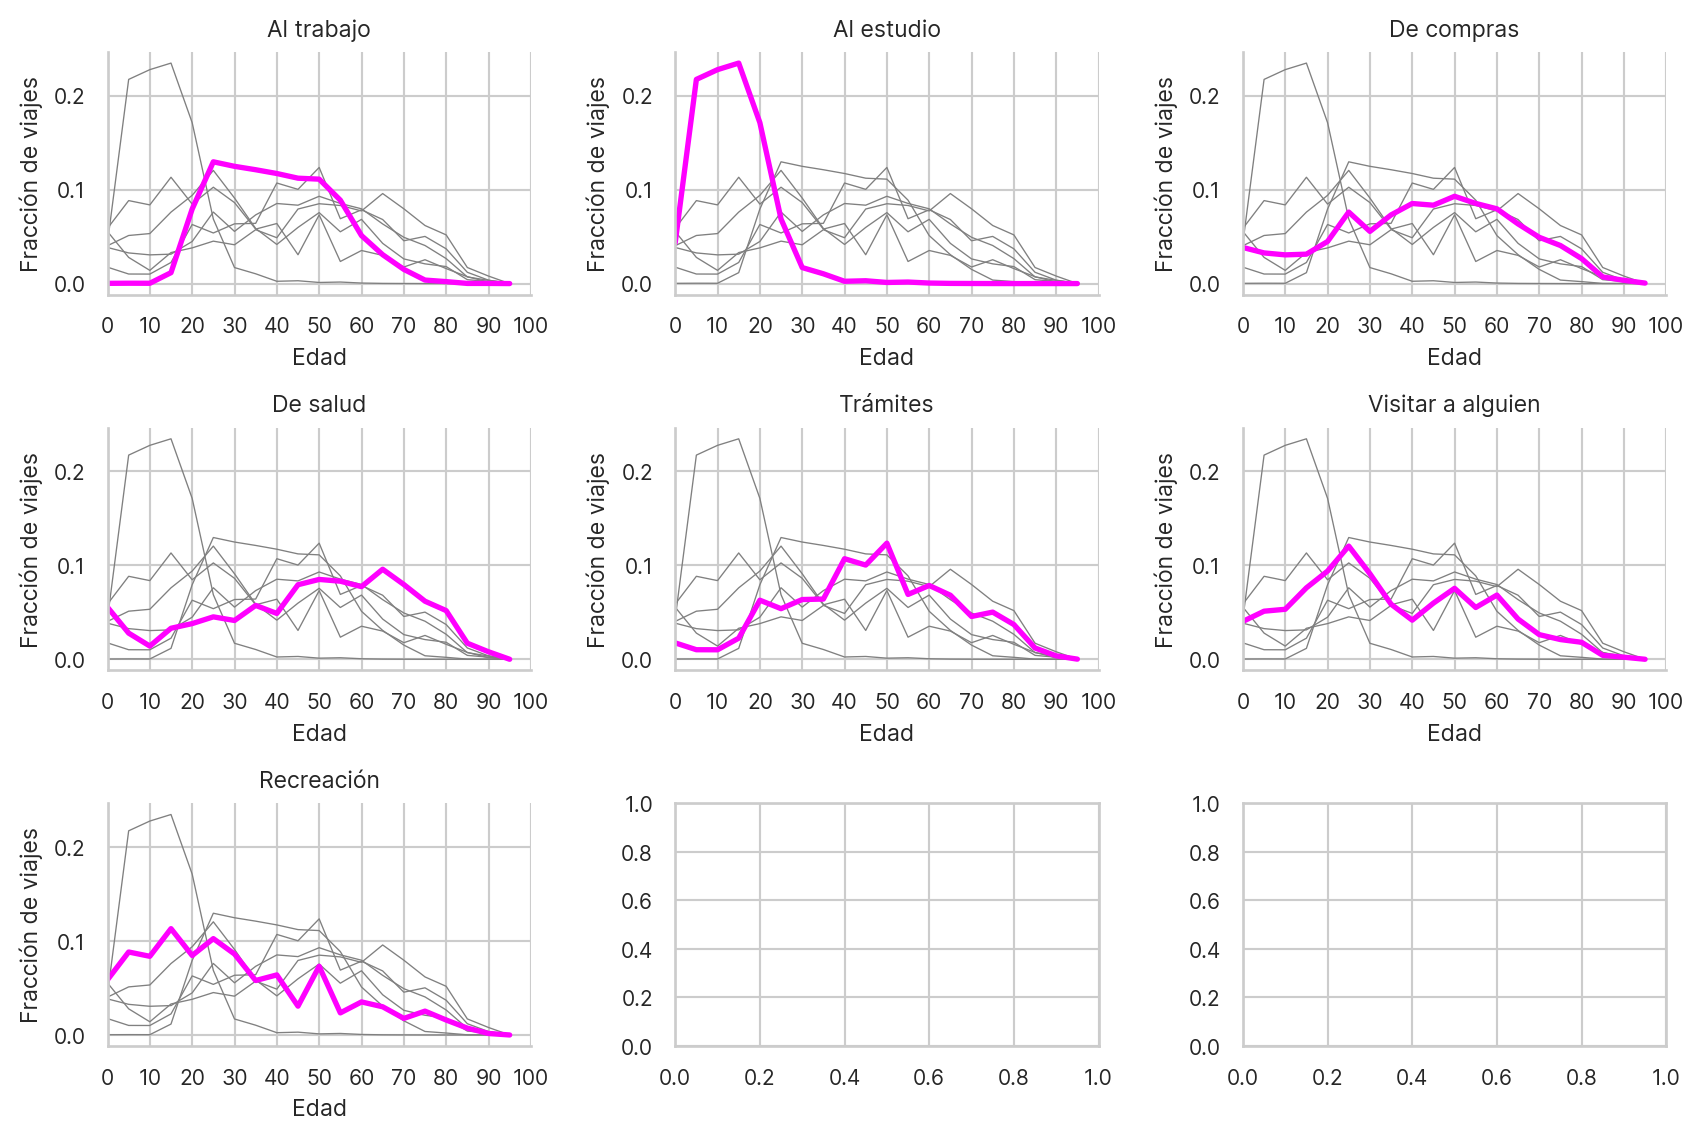

In [47]:
fig_ancho = 6
fig_alto = 2

fig, axes = plt.subplots(
    len(rutina_x_edad.columns) // 2,
    len(rutina_x_edad.columns) // 2,
    figsize=(len(rutina_x_edad.columns) // 2 * 3, len(rutina_x_edad.columns) // 2 * fig_alto),
    sharex=False,
    sharey=False,
    layout='constrained'
)

for col, ax in zip(rutina_x_edad.columns, axes.flatten()):
    rutina_x_edad.plot(color='grey', kind='line', legend=False, linewidth=0.5, ax=ax)
    rutina_x_edad[col].plot(ax=ax, kind="line", color="magenta", linewidth=2)
    ax.set_title(col)
    sns.despine(ax=ax)
    ax.set_xlim([0, 100])
    ax.set_xticks(range(0, 101, 10))
    ax.set_xlabel("Edad")
    ax.set_ylabel("Fracción de viajes")

fig.align_ylabels()
fig.tight_layout()

In [48]:
# wideform 
rutina_x_edad

Proposito,Al trabajo,Al estudio,De compras,De salud,Trámites,Visitar a alguien,Recreación
GrupoEtareo,,,,,,,
0,0.000252,0.043456,0.038422,0.055425,0.017456,0.040310,0.058796
5,0.000366,0.217408,0.032631,0.027848,0.010161,0.051197,0.088355
10,0.000317,0.227799,0.030554,0.014052,0.010095,0.053238,0.083770
15,0.011615,0.234775,0.031305,0.033019,0.022448,0.076087,0.113209
20,0.079360,0.171328,0.044814,0.037989,0.062892,0.093937,0.084641
25,0.129644,0.068727,0.076135,0.045167,0.053879,0.120515,0.102597
30,0.124840,0.017036,0.055544,0.041304,0.063603,0.091070,0.086227
35,0.121212,0.010406,0.073117,0.057335,0.064114,0.058638,0.057994
40,0.117190,0.002433,0.085243,0.048809,0.107063,0.041644,0.063954


In [49]:
# longform
rutina_x_edad_longform = rutina_x_edad.stack().rename("n_viajes").reset_index()
rutina_x_edad_longform.head(5)

,GrupoEtareo,Proposito,n_viajes
0,0,Al trabajo,0.000252
1,0,Al estudio,0.043456
2,0,De compras,0.038422
3,0,De salud,0.055425
4,0,Trámites,0.017456


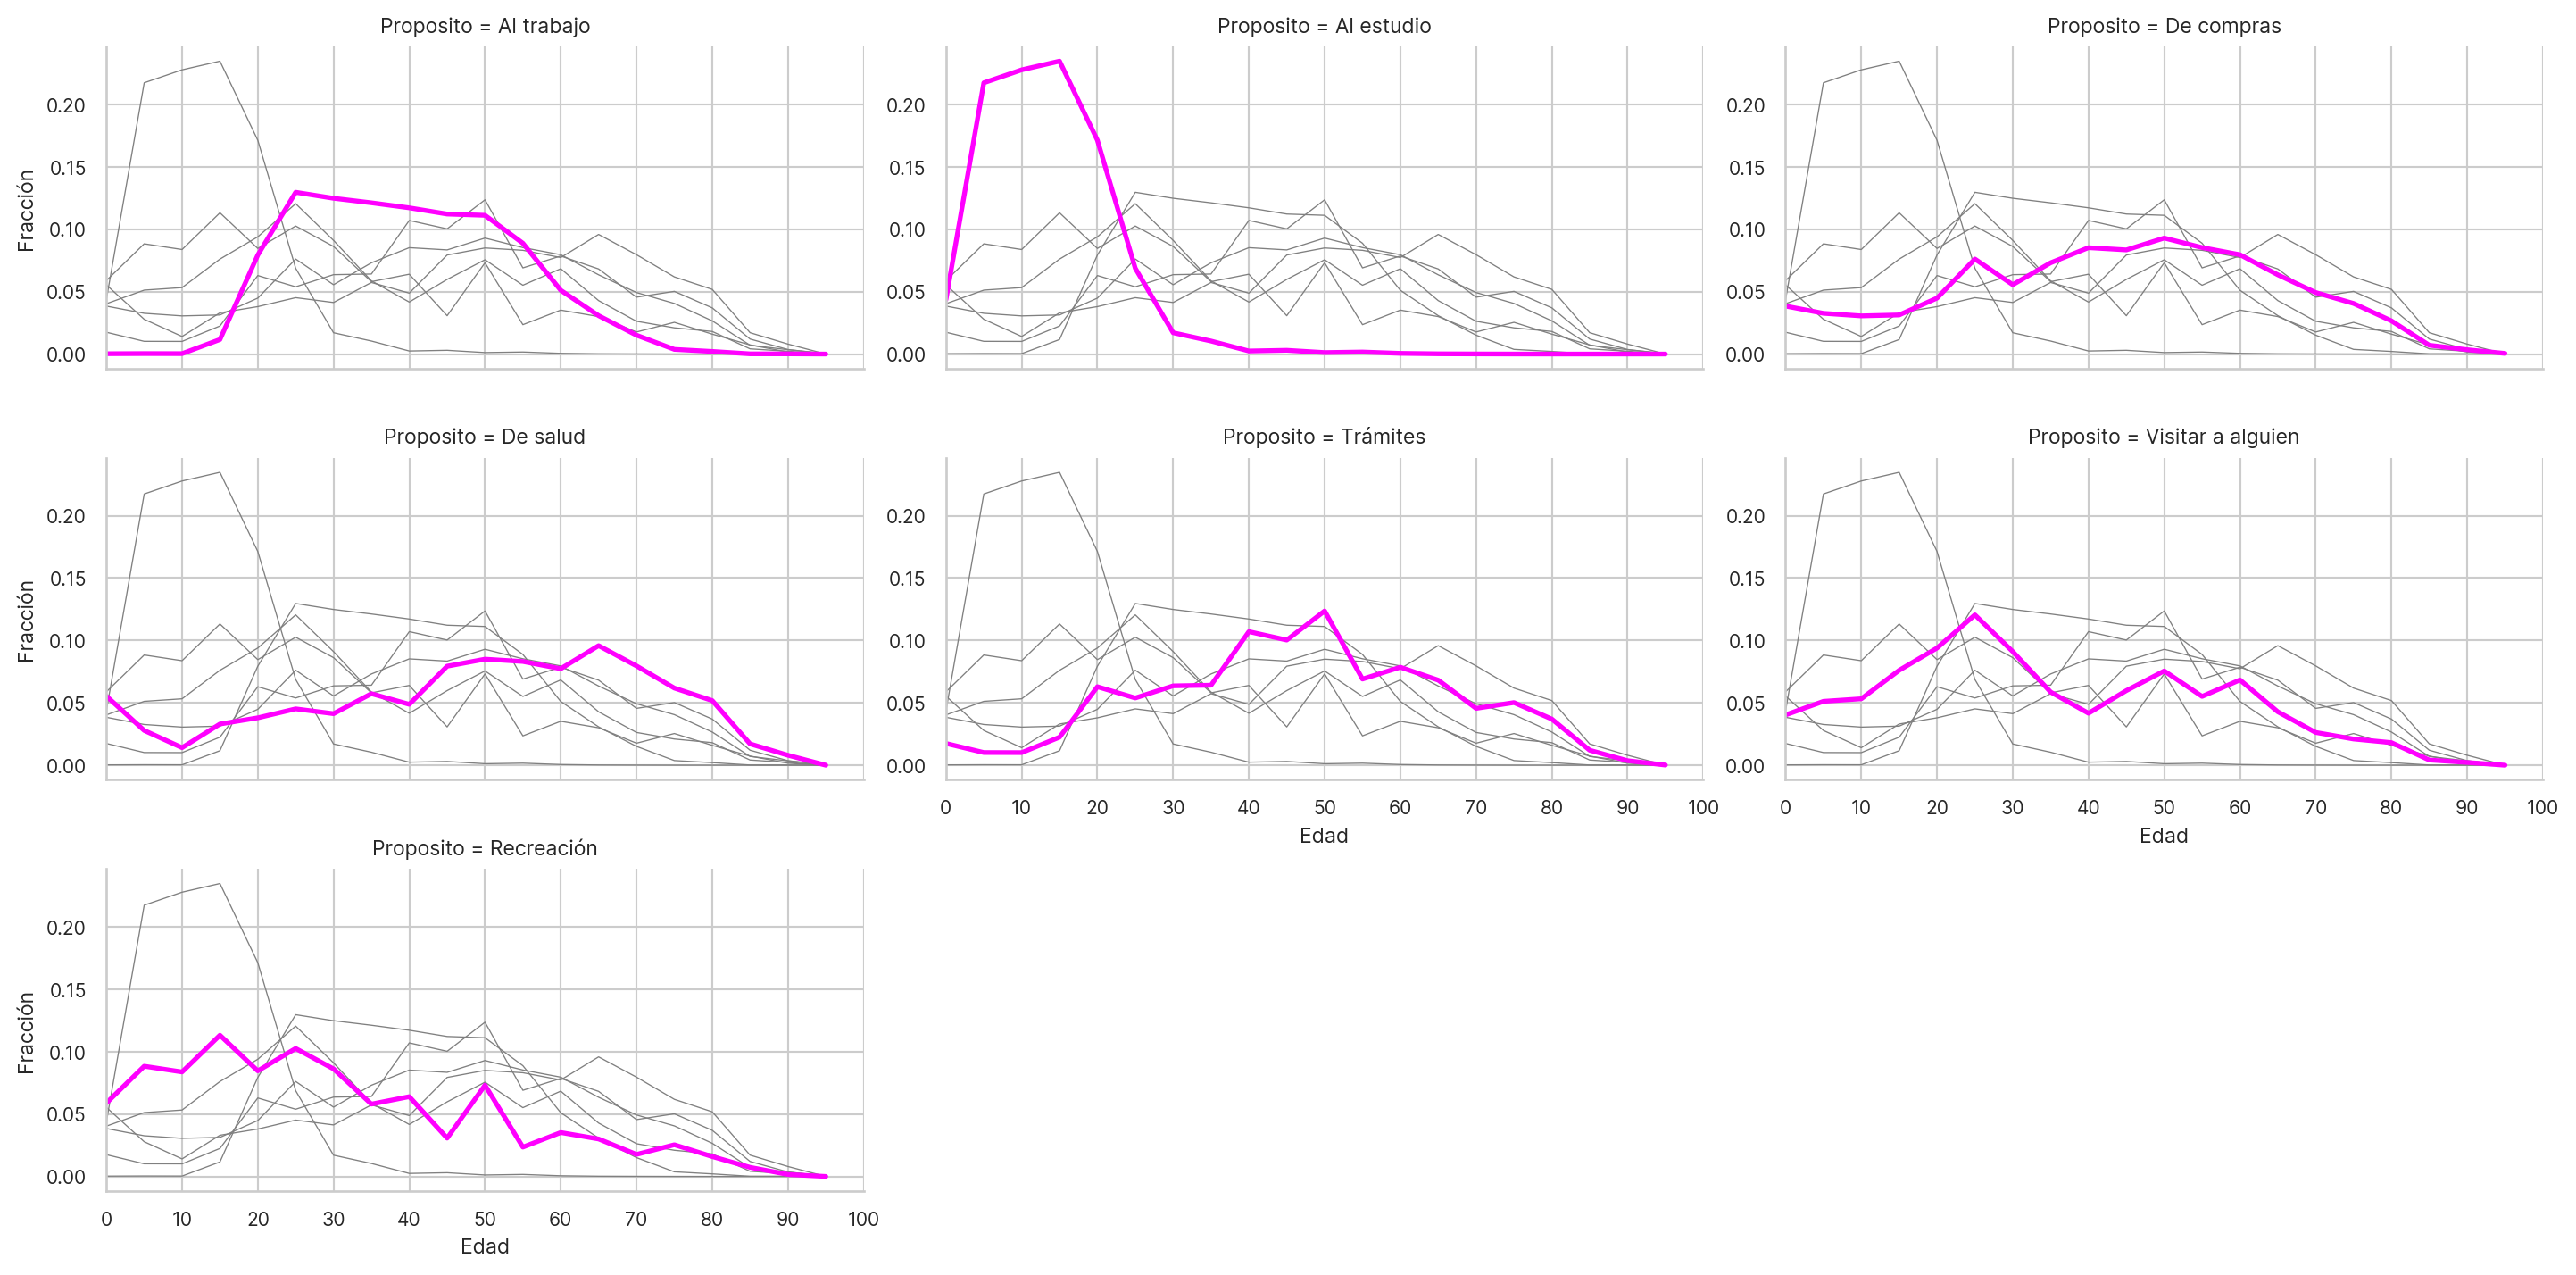

In [50]:
grid = sns.FacetGrid(
    rutina_x_edad_longform,
    col="Proposito",
    col_wrap=3,
    aspect=2,
    height=2.5,
    sharey=False,
)

def plot_todos(*args, **kwargs):
    ax = plt.gca()
    rutina_x_edad.plot(color='grey', kind='line', legend=False, linewidth=0.5, ax=ax)

grid.map(plot_todos)
grid.map(plt.plot, "GrupoEtareo", "n_viajes", color="magenta", linewidth=2)

sns.despine()
grid.set(xlim=[0, 100])
grid.set_xlabels("Edad")
grid.set_ylabels("Fracción")
grid.set(xticks=range(0, 101, 10))
grid.fig.align_ylabels()
#grid.tight_layout()

In [51]:
rutina_x_edad_x_sexo = (
    tabla[
        tabla["Proposito"].isin(
            [
                "Al trabajo",
                "Al estudio",
                "De compras",
                "De salud",
                "Trámites",
                "Visitar a alguien",
                "Recreación",
            ]
        )
    ]
    .groupby(["GrupoEtareo", "Sexo", "Proposito"])["Peso"]
    .sum()
    .unstack(fill_value=0)
    #.pipe(normalize_columns)
    .stack()
    .rename("n_viajes")
    .reset_index()
)

rutina_x_edad_x_sexo

,GrupoEtareo,Sexo,Proposito,n_viajes
0,0,Hombre,Al estudio,18477.776274
1,0,Hombre,Al trabajo,354.432846
2,0,Hombre,De compras,22051.129952
3,0,Hombre,De salud,7484.911368
4,0,Hombre,Recreación,9649.545758
...,...,...,...,...
275,95,Mujer,De compras,458.434763
276,95,Mujer,De salud,0.000000
277,95,Mujer,Recreación,0.000000
278,95,Mujer,Trámites,65.334060


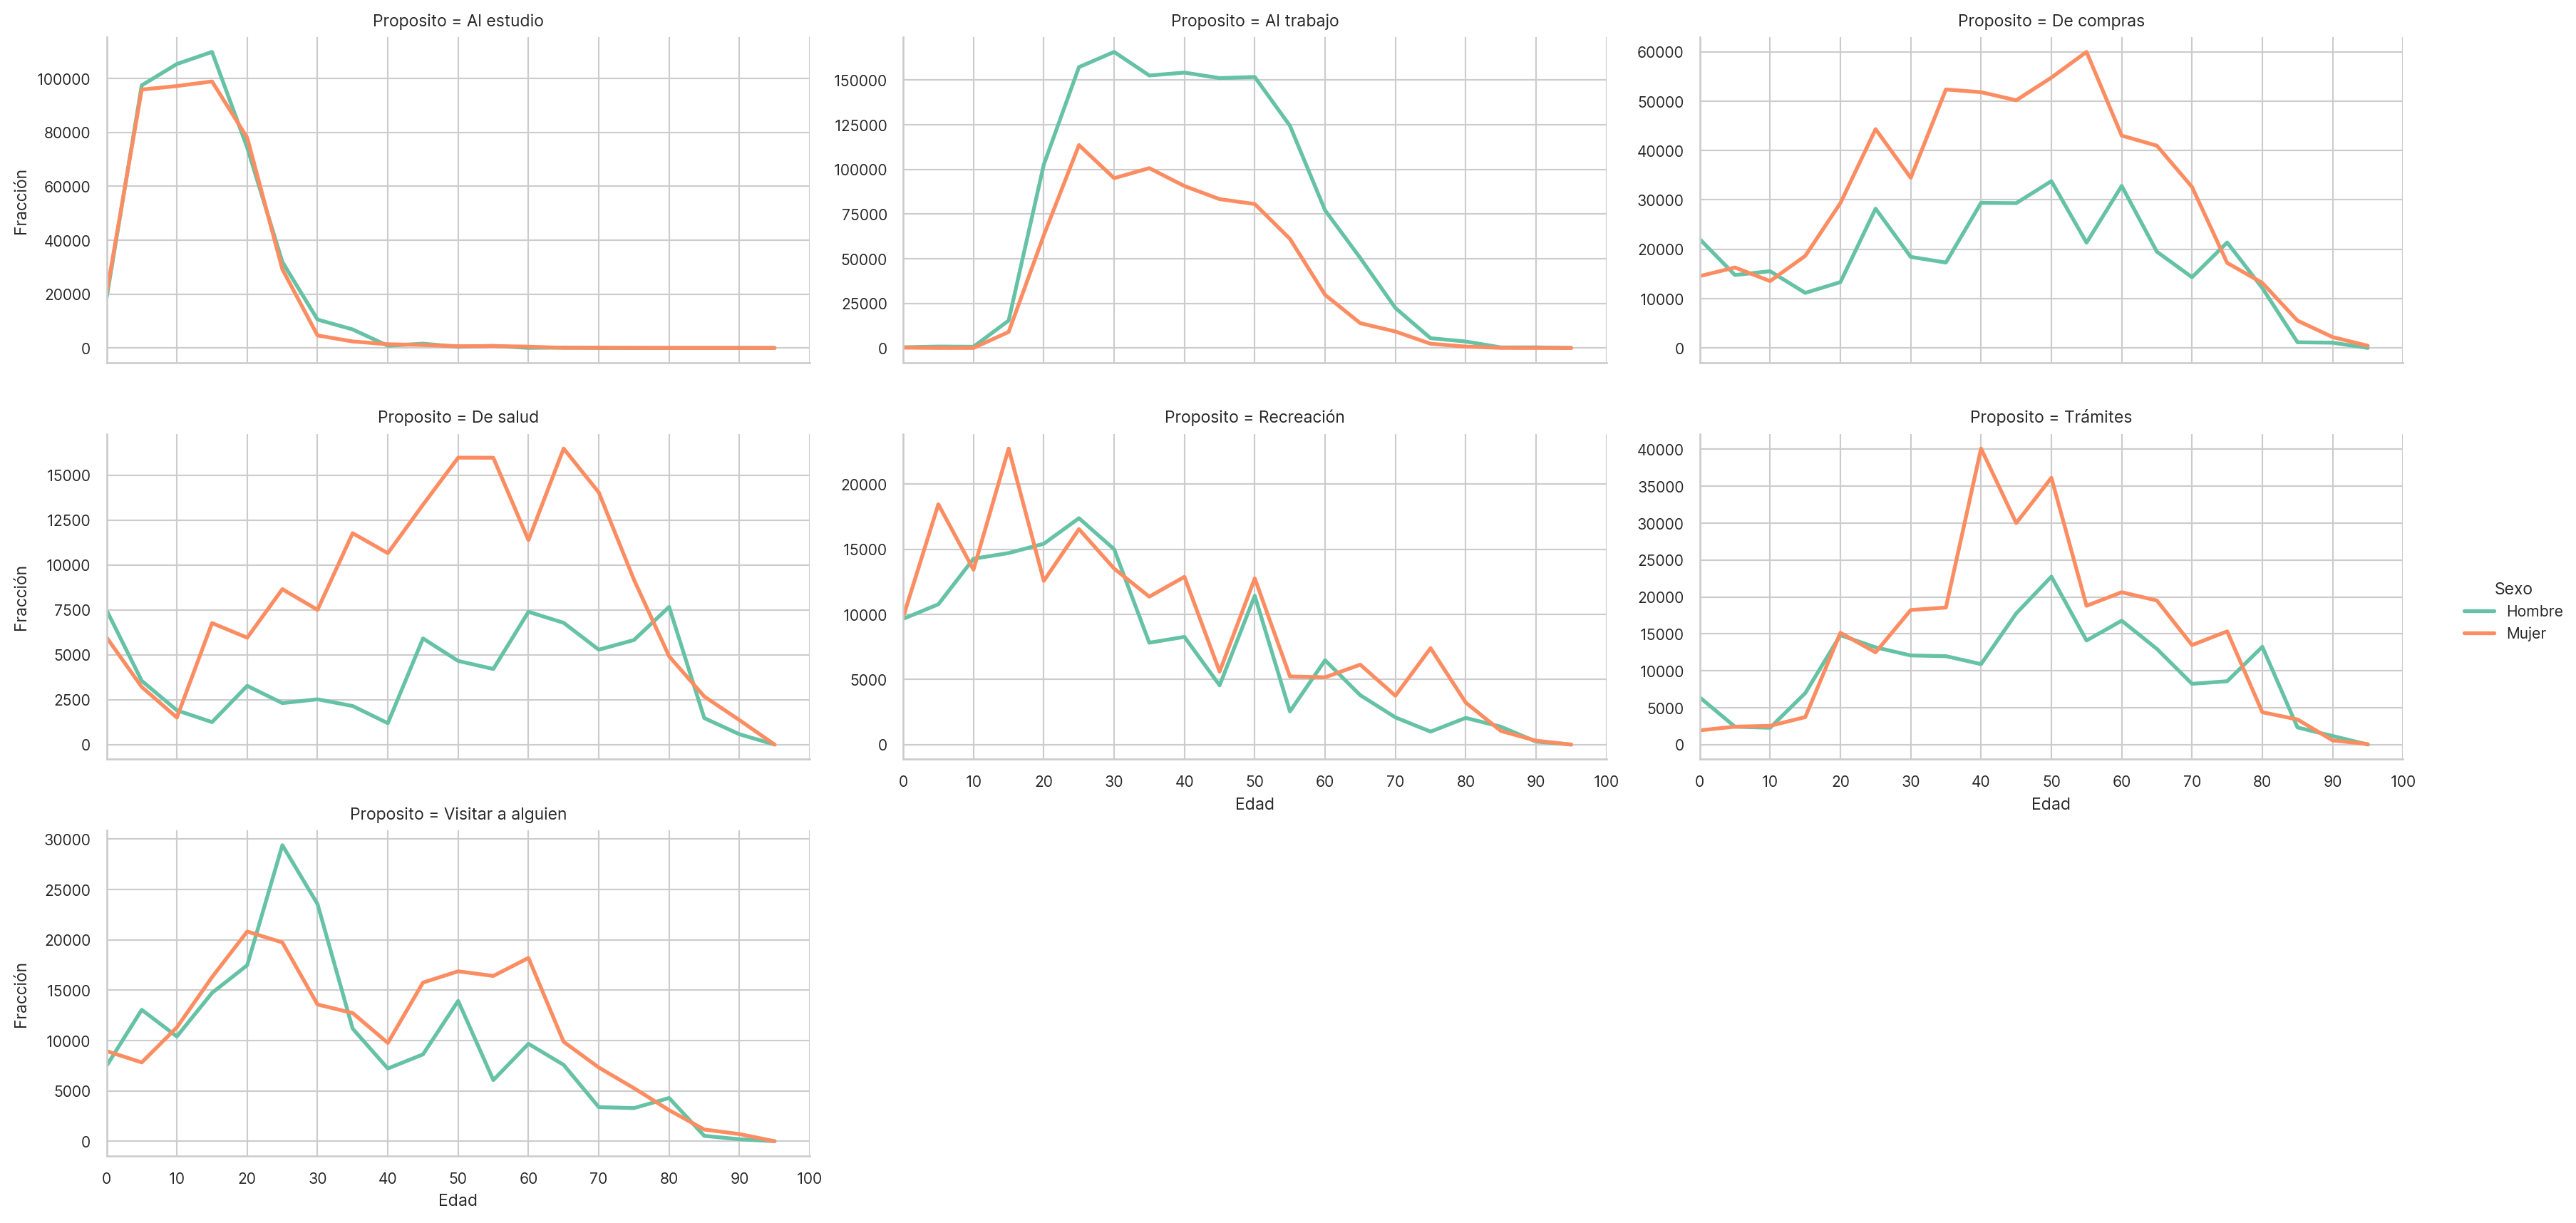

In [52]:
grid = sns.FacetGrid(
    rutina_x_edad_x_sexo,
    col="Proposito",
    col_wrap=3,
    aspect=2,
    height=3,
    sharey=False,
    hue='Sexo', # HSL: Hue (tono), S (saturación), L (luminosidad)
    palette='Set2'
)

grid.map(plt.plot, "GrupoEtareo", "n_viajes", linewidth=2)
grid.add_legend()

sns.despine()
grid.set(xlim=[0, 100])
grid.set_xlabels("Edad")
grid.set_ylabels("Fracción")
grid.set(xticks=range(0, 101, 10))
grid.fig.align_ylabels()
grid.tight_layout()

Observando este gráfico notamos cosas como:

- El aumento de los viajes de salud con la edad hasta los 65 años. Después comienzan a disminuir (recordemos que estamos midiendo viajes relativos).
- La mayor cantidad de personas que sale a comer o tomar algo tiene 30 años.
- Los viajes de buscar o dejar a alguien alcanzan su valor máximo a los 40 años y luego decaen. 
- **¿Qué más observan ustedes?**

Problema propuesto:

- Estudiar el uso de modo de transporte (columna `ModoDifusion`) por grupo etáreo.

## Superimposición

### ¿Existen patrones geográficos en los tipos de actividades que se hacen en una comuna?

In [22]:
CENSUS_GEO_ROOT = Path(os.environ['CENSUS_GEO_ROOT'])

In [23]:
from aves.data.census.loading import read_census_map
comunas = read_census_map('comuna', path=CENSUS_GEO_ROOT / "R13")

In [ ]:
import geopandas as gpd
zones = gpd.read_file(AVES_ROOT / 'data' / 'processed' / 'scl_zonas_urbanas.json').set_index('ID')
zones.head()

In [ ]:
comunas_urbanas = (
    comunas[comunas["COMUNA"].isin(zones["Com"].unique())]
    .drop("NOM_COMUNA", axis=1)
    .copy()
)

comunas_urbanas["NombreComuna"] = comunas_urbanas["COMUNA"].map(
    dict(zip(zones["Com"], zones["Comuna"]))
)

comunas_urbanas.head()

In [ ]:
from aves.features.geo import clip_area_geodataframe

bounding_box = zones.total_bounds
comunas_urbanas = clip_area_geodataframe(comunas_urbanas, zones.total_bounds, buffer=0.001)

In [ ]:
ax = comunas_urbanas.plot()
zones.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.5)

In [ ]:
tabla['Proposito'].value_counts()

In [ ]:
purposes_per_municipality = (
    tabla.drop_duplicates(subset=["Persona", "Proposito"], keep="first")
    .groupby(["ComunaDestino", "Proposito"])["Peso"]
    .sum()
    .unstack(fill_value=0)
)
purposes_per_municipality

In [ ]:
sns.clustermap(purposes_per_municipality.drop('volver a casa', axis=1).pipe(normalize_rows))

In [ ]:
purposes_per_municipality.loc['Santiago'].plot(kind='pie')

In [32]:
trip_activities = {
    "Subsistencia": ["Al estudio", "Al trabajo", "Por trabajo", "Por estudio"],
    "N/A": ["volver a casa"],
    "Mantención": ["De compras", "Trámites", "De salud"],
    "Discrecional": [
        "Buscar o Dejar a alguien",
        "Visitar a alguien",
        "Recreación",
        "Otra actividad (especifique)",
        "Comer o Tomar algo",
        "Buscar o dejar algo",
    ],
}

In [ ]:
from aves.features.utils import normalize_rows

for key, cols in trip_activities.items():
    purposes_per_municipality[key] = purposes_per_municipality[cols].sum(axis=1)

activities_per_municipality = purposes_per_municipality[
    ["Mantención", "Subsistencia", "Discrecional"]
].pipe(normalize_rows)
activities_per_municipality

In [ ]:
sns.clustermap(activities_per_municipality)

In [ ]:
cat_colors = sns.choose_colorbrewer_palette('qualitative')

In [ ]:
from matplotlib.colors import ListedColormap
activities_per_municipality.loc[["Santiago", "La Pintana"]].T.plot(
    kind="pie", subplots=True, cmap=ListedColormap(cat_colors[:3])
)

In [ ]:
from aves.visualization.tables import barchart

fig, ax = plt.subplots(figsize=(14, 7))

barchart(
    ax,
    activities_per_municipality,
    stacked=True,
    normalize=True,
    sort_categories=True,
    sort_items=True,
    palette=cat_colors[:3]
)

# ax.set_title("Uso de Modo de Transporte en Viajes al Trabajo")
# ax.set_xlabel("")
# ax.set_ylabel("Fracción de los Viajes")

In [ ]:
seq_colors = sns.dark_palette(cat_colors[-1], n_colors=5)
seq_colors

In [ ]:
from aves.visualization.figures import small_multiples_from_geodataframe
from aves.visualization.maps import choropleth_map

fig, axes = small_multiples_from_geodataframe(zones, 3, height=5)

for ax, col in zip(axes.flatten(), activities_per_municipality.columns):
    choropleth_map(
        ax,
        comunas_urbanas.join(
            activities_per_municipality[col], on="NombreComuna", how="inner"
        ),
        col,
        k=5,
        palette=seq_colors
    )
    ax.set_title(col)

fig.tight_layout()

In [ ]:
from aves.data.census.analysis import schooling_by_zoning, age_by_zoning, overlay_zoning

intersected_zoning = overlay_zoning(
    comunas_urbanas.drop("REGION", axis=1), crs="EPSG:3857"
)
intersected_zoning.head()

In [41]:
#intersected_zoning.plot()

In [ ]:
nivel_educacional = schooling_by_zoning(intersected_zoning, 'NombreComuna')
nivel_educacional

In [ ]:
zones.crs, comunas_urbanas.crs

In [ ]:
activities_per_municipality = gpd.GeoDataFrame(
    activities_per_municipality,
    geometry=comunas_urbanas.to_crs(zones.crs).set_index("NombreComuna").centroid,
)

activities_per_municipality

In [ ]:
import numpy as np
np.random.rand()

In [ ]:
from aves.visualization.figures import figure_from_geodataframe
from aves.visualization.colors import categorical_color_legend
from aves.visualization.maps import add_basemap, choropleth_map
import matplotlib.patheffects as path_effects


fig, ax = figure_from_geodataframe(zones, height=6)

# add_basemap(ax, AVES_ROOT / "data" / "processed" / "scl_positron_12_balanced.tif", comunas_urbanas)

choropleth_map(
    ax,
    comunas_urbanas.merge(nivel_educacional[["NombreComuna", "promedio"]]).to_crs(
        zones.crs
    ),
    "promedio", palette=seq_colors, linewidth=0.5, k=5, edgecolor='black'
)

for idx, row in activities_per_municipality.iterrows():
    # posición en el espacio (coordenadas geográficas)
    pos = (row["geometry"].x, row["geometry"].y)
    # posición en el gráfico (coordenadas absolutas)
    p = ax.transData.transform_point(pos)
    # posición en la figura (coordenadas relativas)
    p = fig.transFigure.inverted().transform_point(p)

    pie_size = 0.03 # np.random.rand() * 0.1
    pie_bounds = [p[0] - pie_size * 0.5, p[1] - pie_size * 0.5, pie_size, pie_size]

    box_inset = fig.add_axes(pie_bounds, label=idx)

    box_inset.pie(
        row[["Mantención", "Subsistencia", "Discrecional"]].values,
        wedgeprops=dict(edgecolor="black", linewidth=0.5),
        colors=cat_colors[:3],
    )

    pos_y = 1.0
    va = "bottom"
    continue
    t = box_inset.annotate(
        idx,
        (0.5, pos_y),
        xycoords="axes fraction",
        horizontalalignment="center",
        va=va,
        fontsize=6,
        fontweight="bold",
        color="white",
    )
    t.set_path_effects(
        [path_effects.Stroke(linewidth=2, foreground="black"), path_effects.Normal()]
    )

ax.set_title("Actividades Realizadas en Cada Comuna")


categorical_color_legend(
    ax, cat_colors[:3], ["Mantención", "Subsistencia", "Discrecional"], loc="center left"
)

In [ ]:
from io import StringIO

# gracias a https://github.com/hafen/geofacet/issues/148
scl_grid_positions = '''row,col,name,code
1,3,QUILICURA,13125
1,4,CONCHALÍ,13104
1,7,HUECHURABA,13107
1,8,LO BARNECHEA,13115
2,3,RENCA,13128
2,4,QUINTA NORMAL,13126
2,5,INDEPENDENCIA,13108
2,6,RECOLETA,13127
2,7,VITACURA,13132
2,8,LAS CONDES,13114
3,2,PUDAHUEL,13124
3,3,CERRO NAVIA,13103
3,4,ESTACIÓN CENTRAL,13106
3,5,SANTIAGO,13101
3,6,PROVIDENCIA,13123
3,7,ÑUÑOA,13120
3,8,LA REINA,13113
4,3,LO PRADO,13117
4,4,PEDRO AGUIRRE CERDA,13121
4,5,SAN MIGUEL,13130
4,6,MACUL,13118
4,7,PEÑALOLÉN,13122
5,2,MAIPÚ,13119
5,3,CERRILLOS,13102
5,4,LO ESPEJO,13116
5,5,LA CISTERNA,13109
5,6,SAN JOAQUÍN,13129
5,7,LA FLORIDA,13110
6,1,PADRE HURTADO,13604
6,4,EL BOSQUE,13105
6,5,SAN RAMÓN,13131
6,6,LA GRANJA,13111
6,7,PUENTE ALTO,13201
6,8,SAN JOSÉ DE MAIPO,13203
7,4,SAN BERNARDO,13401
7,5,LA PINTANA,13112
7,6,PIRQUE,13202'''

scl_grid_positions = pd.read_csv(StringIO(scl_grid_positions))
scl_grid_positions

In [ ]:
comuna_x_grid = scl_grid_positions.set_index(['row', 'col'])['name'].str.title().to_dict()
comuna_x_grid

In [ ]:
activities_per_municipality

In [ ]:
comuna_x_grid[(4, 4)] in activities_per_municipality.index

In [ ]:
n_rows = scl_grid_positions['row'].max()
n_cols = scl_grid_positions['col'].max()

fig, axes = plt.subplots(n_rows, n_cols, figsize=(7,7))

for ax in axes.flatten():
    ax.set_axis_off()

for i in range(n_rows):
    for j in range(n_cols):
        pos = (i + 1, j + 1)
        if not pos in comuna_x_grid:
            continue
        if not comuna_x_grid[pos] in activities_per_municipality.index:
            continue
        
        #print(i, j, comuna_x_grid[pos], activities_per_municipality.loc[comuna_x_grid[pos]])

        ax = axes[i,j]

        ax.pie(
            activities_per_municipality.loc[comuna_x_grid[pos]][["Mantención", "Subsistencia", "Discrecional"]].values,
            wedgeprops=dict(edgecolor="black", linewidth=0.5),
            colors=cat_colors[:3],
        )

        ax.set_title(comuna_x_grid[pos])


fig.tight_layout()
fig.align_titles()

categorical_color_legend(
    axes[n_rows-1,0], cat_colors[:3], ["Mantención", "Subsistencia", "Discrecional"], loc="center left"
)

## _Widgets_ interactivos

In [87]:
%matplotlib ipympl

In [88]:
import numpy as np

In [89]:
import ipywidgets as widgets

In [ ]:
from IPython.display import display, clear_output


class ODMatrix(widgets.HBox):

    def __init__(self, df):
        super().__init__()
        self.df = df
        self.output = widgets.Output()
        self.proposito = []
        self.modos = []
        self.transformacion = ""
        self.fig = None
        self.ax = None

        self.row_order = sorted(self.df["ComunaOrigen"].unique())

        controls = self.create_control_panel()
        self.children = [controls, self.output]

    def create_control_panel(self):
        widget_proposito = widgets.Dropdown(
            options=['Todos'] + list(tabla["Proposito"].unique()),
            description="Propósito:",
            disabled=False,
        )

        widget_modo = widgets.SelectMultiple(
            options=['Todos'] + list(tabla["ModoDifusion"].unique()),
            description="Modo de transporte:",
            disabled=False,
        )

        widget_proposito.observe(self.update_proposito, "value")
        widget_modo.observe(self.update_modo, "value")

        return widgets.VBox([widget_proposito, widget_modo])

    def update_proposito(self, change):
        self.proposito = change["new"]
        self.plot()

    def update_modo(self, change):
        self.modos = list(change["new"])
        self.plot()

    def plot(self):
        with self.output:
            clear_output(wait=True)
            if self.fig:
                self.fig.clf()
                self.ax = None

            self.fig, self.ax = plt.subplots(figsize=(6, 6))

            viajes = self.df
            if self.proposito and not self.proposito == 'Todos':
                viajes = viajes[viajes["Proposito"] == self.proposito]
            if self.modos and not self.modos[0] == 'Todos':
                viajes = viajes[viajes["ModoDifusion"].isin(self.modos)]

            matriz = (
                viajes.groupby(["ComunaOrigen", "ComunaDestino"])["Peso"]
                .sum()
                .unstack(fill_value=0)
                .pipe(normalize_rows)
                .join(pd.DataFrame(index=self.row_order), how='outer')
                .fillna(0)
            )

            for col in self.row_order:
                if not col in matriz.columns:
                    matriz[col] = 0

            matriz = matriz[self.row_order]


            sns.heatmap(matriz, ax=self.ax, cbar=False, cmap=res)
            self.ax.set_title(
                f"Matriz OD {self.transformacion}\n{repr(self.proposito)} / {repr(self.modos)}"
            )

            self.ax.set_xlabel('Comuna de Destino')
            self.ax.set_ylabel('Comuna de Origen')

            # esto evita que lo muestre el notebook debajo de los widgets.
            plt.close()

            # esto muestra la figura _en_ el widget
            display(self.fig)
            


ODMatrix(tabla)